In [15]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from distance import *
from mi_density import *
from utils import *

from pymatgen.core import Structure

import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import mpl_style

# Add the font file
fpath = Path("/Users/andrewf/Library/Fonts/dejavu-sans.condensed.ttf")
mpl.font_manager.fontManager.addfont(fpath)
if fpath.exists():
    # Add the font to the font manager
    mpl.font_manager.fontManager.addfont(str(fpath))
    
    # Create font properties object
    prop = mpl.font_manager.FontProperties(fname=str(fpath))
    font_name = prop.get_name()
    
    # Set as default
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [font_name]
    
    # Set specific text properties 
    # For newer matplotlib versions
    mpl.rc('font', **{'family': 'sans-serif', 'sans-serif': [font_name]})
    
    def apply_condensed_font(fig):
        for ax in fig.axes:
            # Apply to all text elements on the axes
            for text in ax.texts:
                text.set_fontproperties(prop)
            
            # Apply to title and axis labels
            ax.title.set_fontproperties(prop)
            ax.xaxis.label.set_fontproperties(prop)
            ax.yaxis.label.set_fontproperties(prop)
            
            # Apply to tick labels
            for label in ax.get_xticklabels():
                label.set_fontproperties(prop)
            for label in ax.get_yticklabels():
                label.set_fontproperties(prop)
            
            # Apply to legend if it exists
            legend = ax.get_legend()
            if legend:
                # Apply to legend title
                if legend.get_title():
                    legend.get_title().set_fontproperties(prop)
                
                # Apply to legend text
                for text in legend.get_texts():
                    text.set_fontproperties(prop)


import warnings
warnings.filterwarnings("ignore")

In [16]:
MAT_DB = "perovskite_re"

# get all cif files in folder
files = [file for file in os.listdir(MAT_DB) if ".cif" in file]

structures = []
formulas = []
space_group_numbers = []
unit_cell_vols = []
for filename in files:
    structure = Structure.from_file(os.path.join(MAT_DB, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))
    space_group_numbers.append(structure.get_space_group_info()[1]) 
    unit_cell_vols.append(structure.volume)


data = pd.DataFrame({"formula": formulas, "structure": structures, "spacegroup": space_group_numbers, "volume": unit_cell_vols, "filename": files})

In [17]:
use_precomputed = True

if use_precomputed:
    lostop_dm = np.load(f"precomputed/{MAT_DB}_lostop_dm.npy")
    elmd_dm = np.load(f"precomputed/{MAT_DB}_elmd_dm.npy")
else:
    lostop_dm = get_lostop_dm(data["structure"].values)
    np.save(f"precomputed/{MAT_DB}_lostop_dm.npy", lostop_dm)

    elmd_dm = get_elmd_dm(data["formula"].values)
    np.save(f"precomputed/{MAT_DB}_elmd_dm.npy", elmd_dm)

In [18]:
df = pd.DataFrame()
mi_data = {}

for dm, name in zip([lostop_dm, elmd_dm], ["lostop", "elmd"]):

    cutoff, mi_profile = get_MI_profile(dm, n_thresholds=250)

    mi_data[name] = [cutoff, mi_profile]

    print(f"MI cutoff for {name}: {cutoff}")

    df[f'{name}_density'] = compute_mi_density(dm, cutoff, mi_profile)

df['formula'] = data['formula']
df['filename'] = data['filename']
df['spacegroup'] = data['spacegroup']
df['volume'] = data['volume']

MI cutoff for lostop: 0.6601161762377981
MI cutoff for elmd: 7.209638554216867


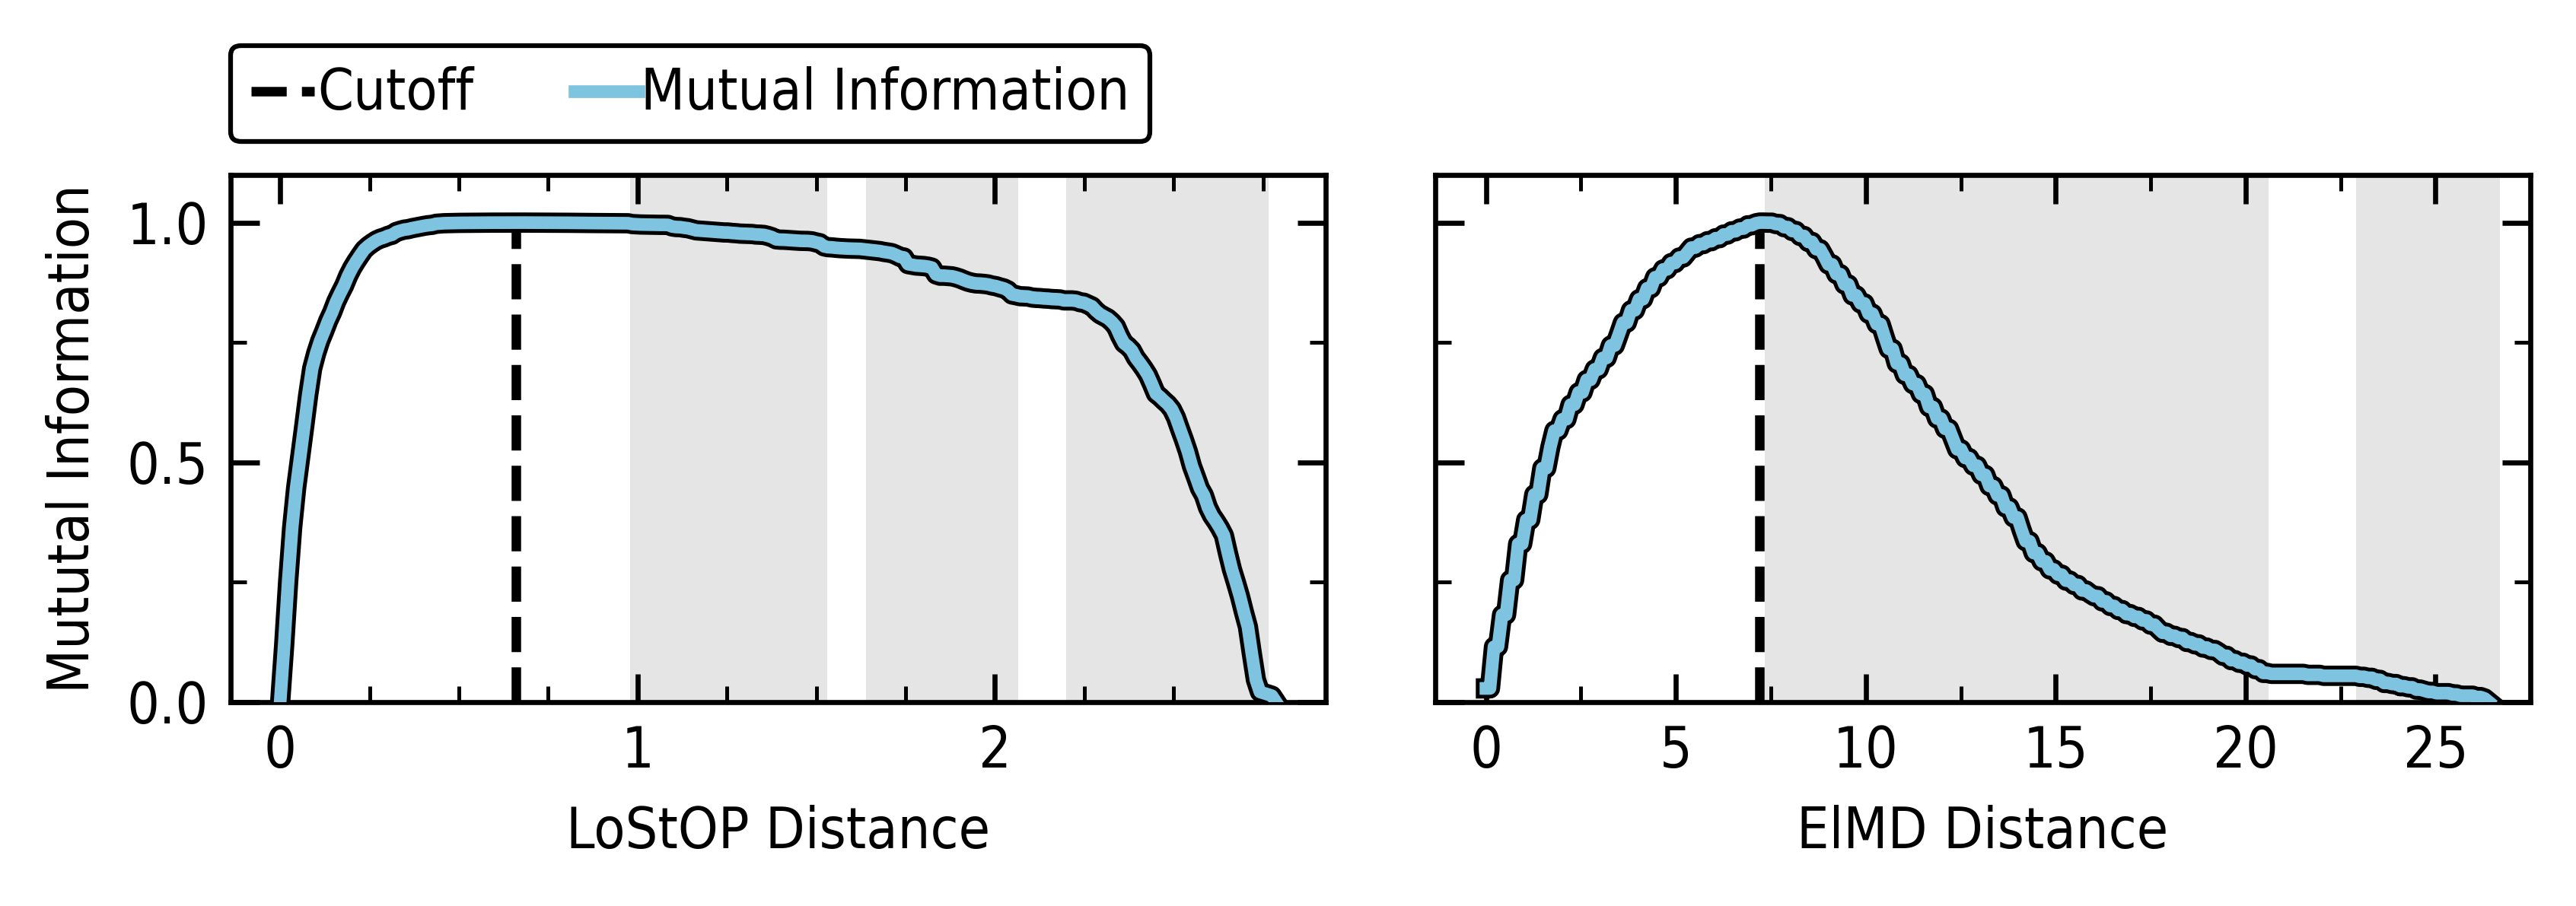

In [135]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 1.5), sharey=True, dpi=600)

# adjust the space between the subplots
plt.subplots_adjust(wspace=0.1)

ax[0].add_patch(Rectangle((0.98, 0.0), 0.55, 1.1, color='k', alpha=0.1, lw=0))
ax[0].add_patch(Rectangle((1.64, 0.0), 0.425, 1.1, color='k', alpha=0.1, lw=0))
ax[0].add_patch(Rectangle((2.2, 0.0), 0.565, 1.1, color='k', alpha=0.1, lw=0))

ax[0].vlines(x=mi_data['lostop'][0], ymin=0, ymax=1.0, color='black', lw=1.5, ls='--', label='Cutoff')
ax[0].plot(np.linspace(0, np.max(lostop_dm), 250), mi_data['lostop'][1], zorder=10, color='black', lw=3.2,)
ax[0].plot(np.linspace(0, np.max(lostop_dm), 250), mi_data['lostop'][1], zorder=10, color='#7EC3E0', lw=2, label='Mutual Information')
ax[0].set_yticks([0, 0.5, 1.0])
ax[0].set_ylim(0, 1.1)
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].set_ylabel("Mututal Information")
ax[0].set_xlabel("LoStOP Distance")

ax[1].add_patch(Rectangle((7.35, 0.0), 13.25, 1.1, color='k', alpha=0.1, lw=0))
ax[1].add_patch(Rectangle((22.9, 0.0), 3.8, 1.1, color='k', alpha=0.1, lw=0))
ax[1].vlines(x=mi_data['elmd'][0], ymin=0, ymax=1, color='black', lw=1.5, ls='--', label='Cutoff')
ax[1].plot(np.linspace(0, np.max(elmd_dm), 250), mi_data['elmd'][1], zorder=10, color='black', lw=3.2,)
ax[1].plot(np.linspace(0, np.max(elmd_dm), 250), mi_data['elmd'][1], zorder=10, color='#7EC3E0', lw=2, label='Mutual Information')
ax[1].set_xlim(None, 27.5)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2.5))
ax[1].set_xlabel("ElMD Distance")

legend = ax[0].legend(loc='lower center', fontsize=8, frameon=True, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(0.42, 1.0), ncol=2)
legend.get_frame().set_linewidth(0.75)


apply_condensed_font(fig)

plt.show()

In [ ]:
w, h = 4, 3
margin = 0.5
fig = plt.figure(figsize=(w, h), facecolor='lightblue')
ax = fig.add_axes([margin / w, margin / h, (w - 2 * margin) / w,
                      (h - 2 * margin) / h])

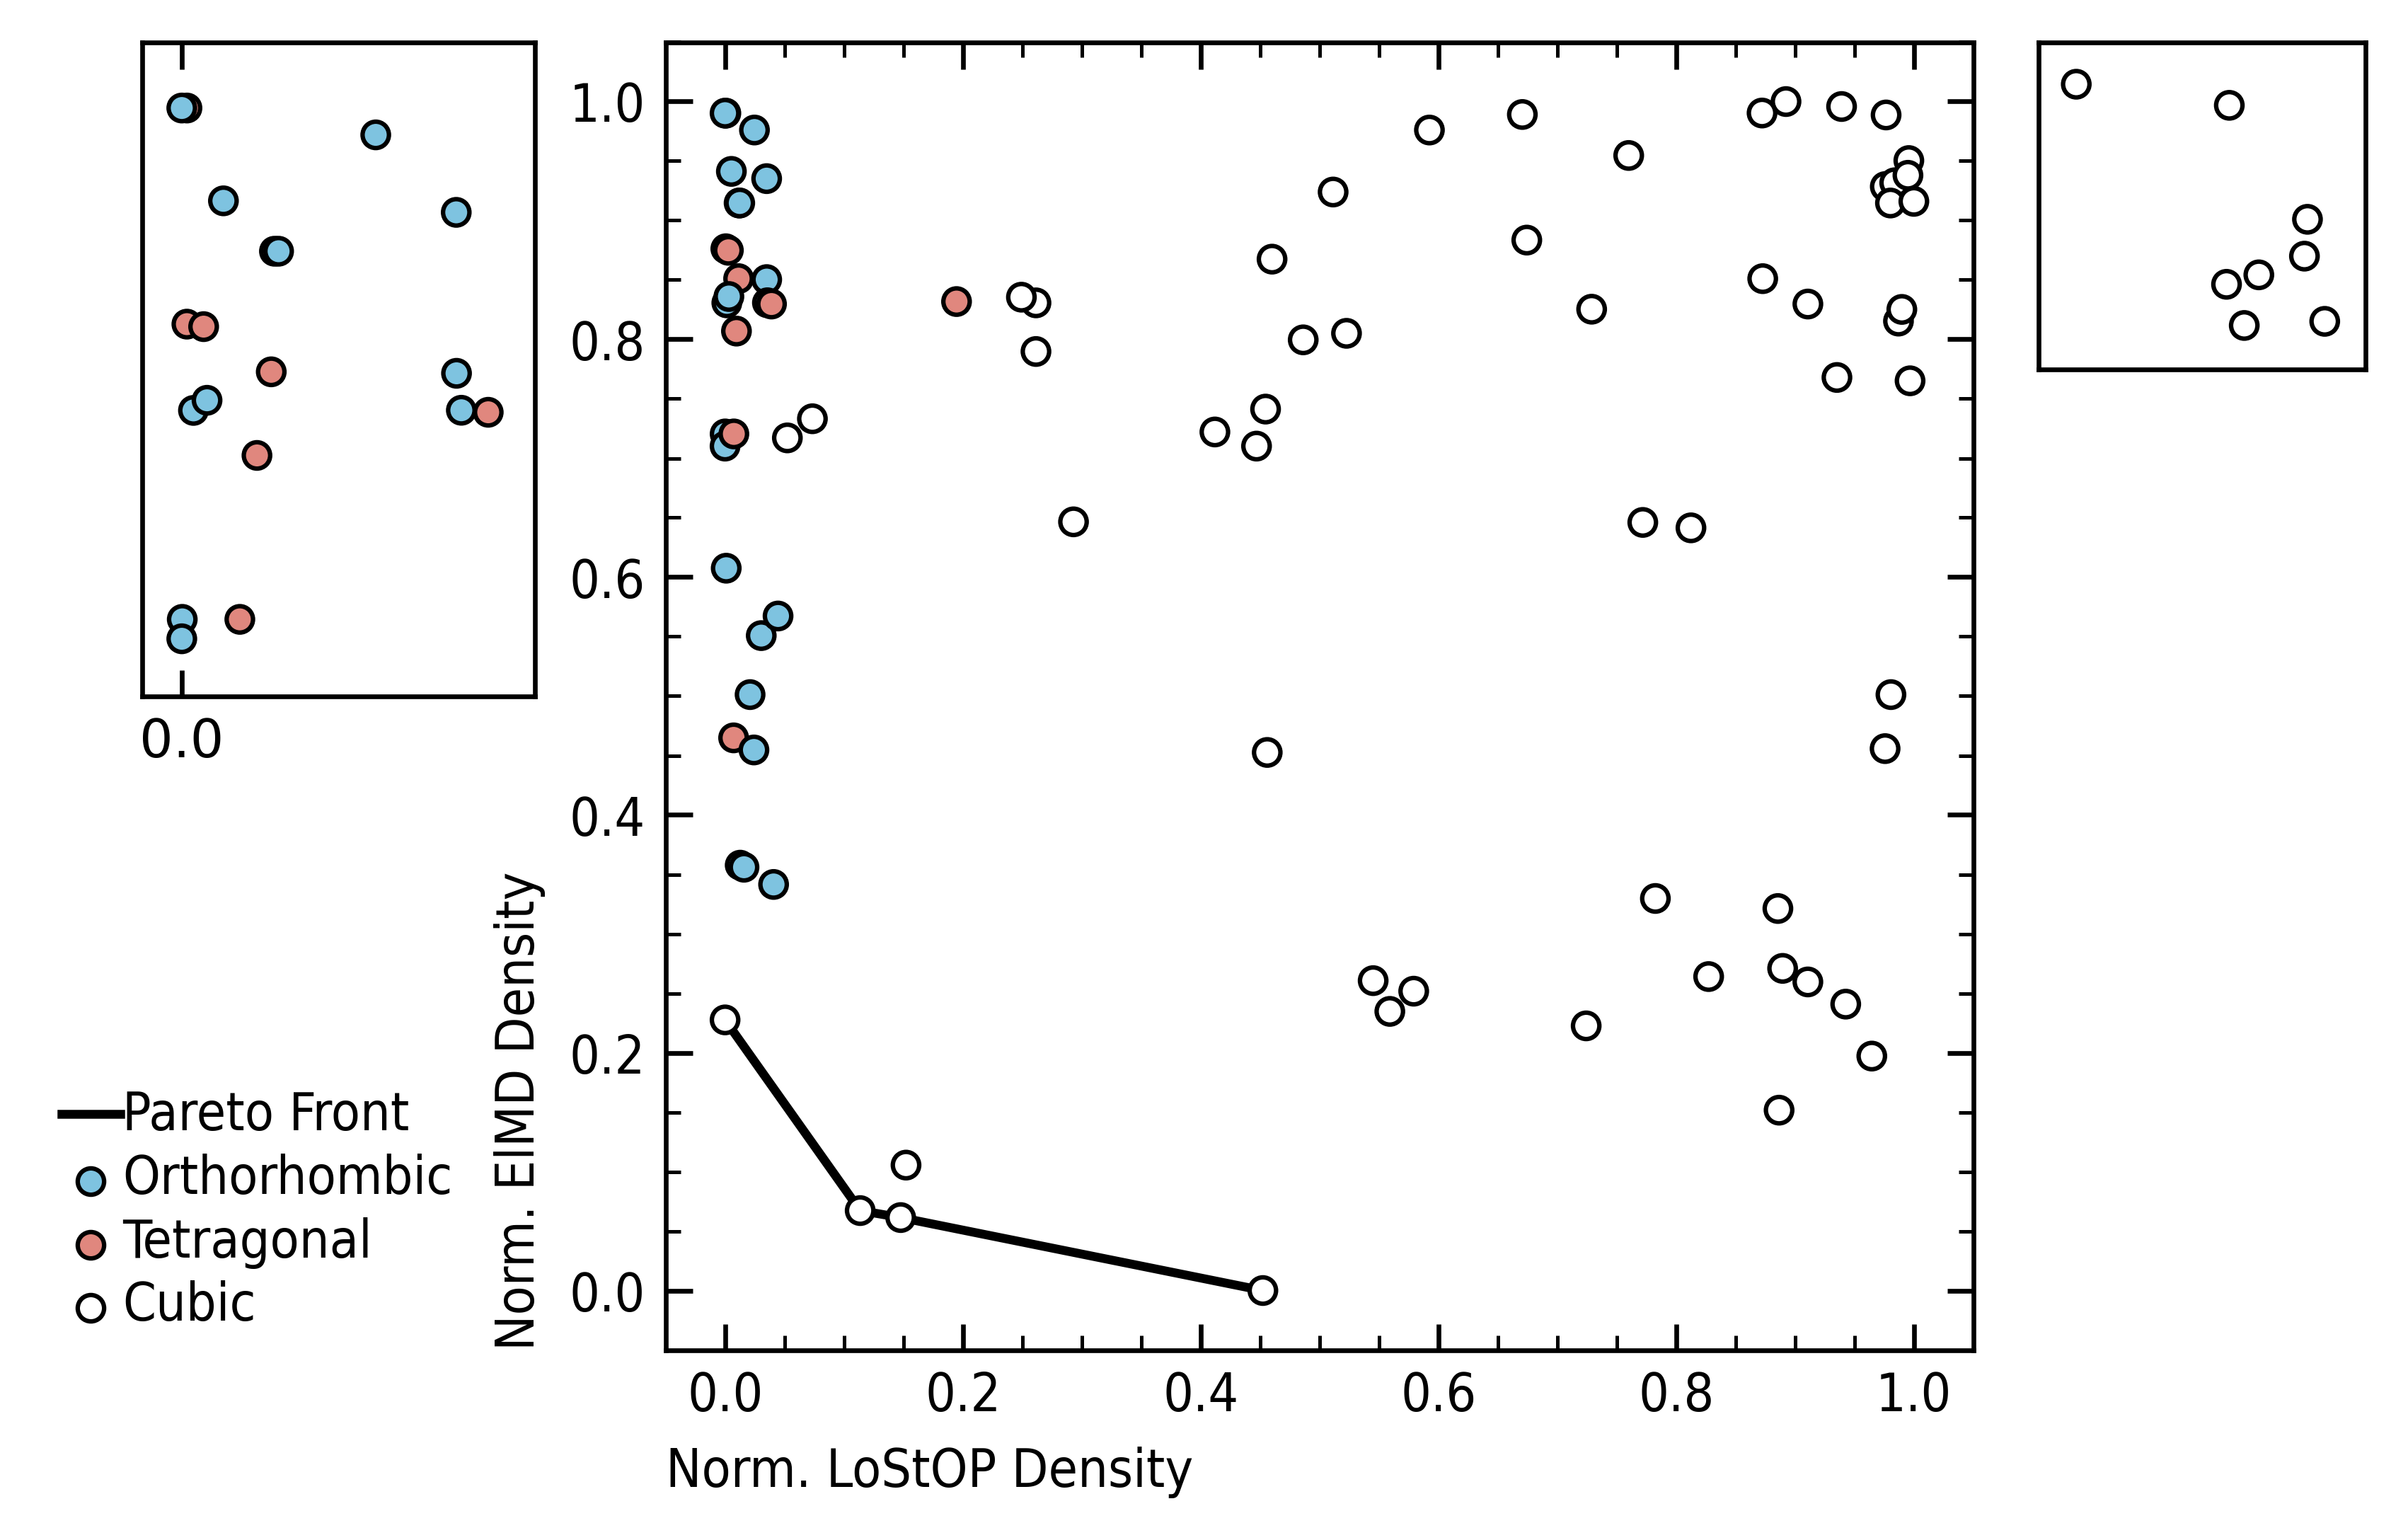

In [139]:
fig, ax = plt.subplots(figsize=(6.5, 4), dpi=600)
ax.set_aspect('equal')

scaled_df = df.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

p_idx = is_pareto_efficient(scaled_df[['lostop_density', 'elmd_density']].values, return_mask=False)
# pareto_labels = [labels[i] for i in p_idx]
pareto_x = scaled_df['lostop_density'].loc[p_idx]
pareto_y = scaled_df['elmd_density'].loc[p_idx]
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))
ax.plot(pareto_x, pareto_y, color='k', lw=1.5, ls='-', marker='None', label='Pareto Front')

cmap = mpl.colors.ListedColormap(["#7EC3E0", "#E0877E", "#FFF"]) # blue, red, white, ortho, tet, cube

ax.scatter(scaled_df['lostop_density'], scaled_df['elmd_density'], c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')

ax.scatter([],[], c='#7EC3E0', label='Orthorhombic', s=20, zorder=9, lw=0.75, ec='k')
ax.scatter([],[], c='#E0877E', label='Tetragonal', s=20, zorder=9, lw=0.75, ec='k')
ax.scatter([],[], c='#FFF', label='Cubic', s=20, zorder=9, lw=0.75, ec='k')

ax.set_xlabel("Norm. LoStOP Density", loc='left')
ax.set_ylabel("Norm. ElMD Density", loc='bottom')

# get axis limits
ax_xlim = ax.get_xlim()
ax_ylim = ax.get_ylim()

# create left inset axes
axins_left = ax.inset_axes(
    [-0.4, 0.5, 0.3, 0.5],
    xlim=(-0.005, 0.045), 
    ylim=(0.68, 1.025), 
    yticks=[],
    xticks=[0.0],
    xticklabels=["0.0"],
    yticklabels=[])

axins_left.tick_params(axis='both', which='minor', length=0)
axins_left.scatter(scaled_df['lostop_density']+1e-10, scaled_df['elmd_density'], c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')
# ax.indicate_inset_zoom(axins_left, edgecolor="black", alpha=1.0, lw=0.75)

# create right inset axes
axins_right = ax.inset_axes(
    [1.05, 0.75, 0.25, 0.25],
    xlim=(0.93, 1.01), 
    ylim=(0.9, 1.01), 
    yticks=[],
    xticks=[],
    xticklabels=[],
    yticklabels=[])
axins_right.tick_params(axis='both', which='minor', length=0)
axins_right.scatter(scaled_df['lostop_density'], scaled_df['elmd_density']+1e-10, c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')
# ax.indicate_inset_zoom(axins_right, edgecolor="black", alpha=1.0, lw=0.75)


# legend = plt.legend(loc='lower left', fontsize=8, frameon=True, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(1.0275, -0.024))
legend = plt.legend(loc='lower left', fontsize=8, frameon=False, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(-0.5, -0.024))
legend.get_frame().set_linewidth(0.75)
apply_condensed_font(fig)
plt.show()

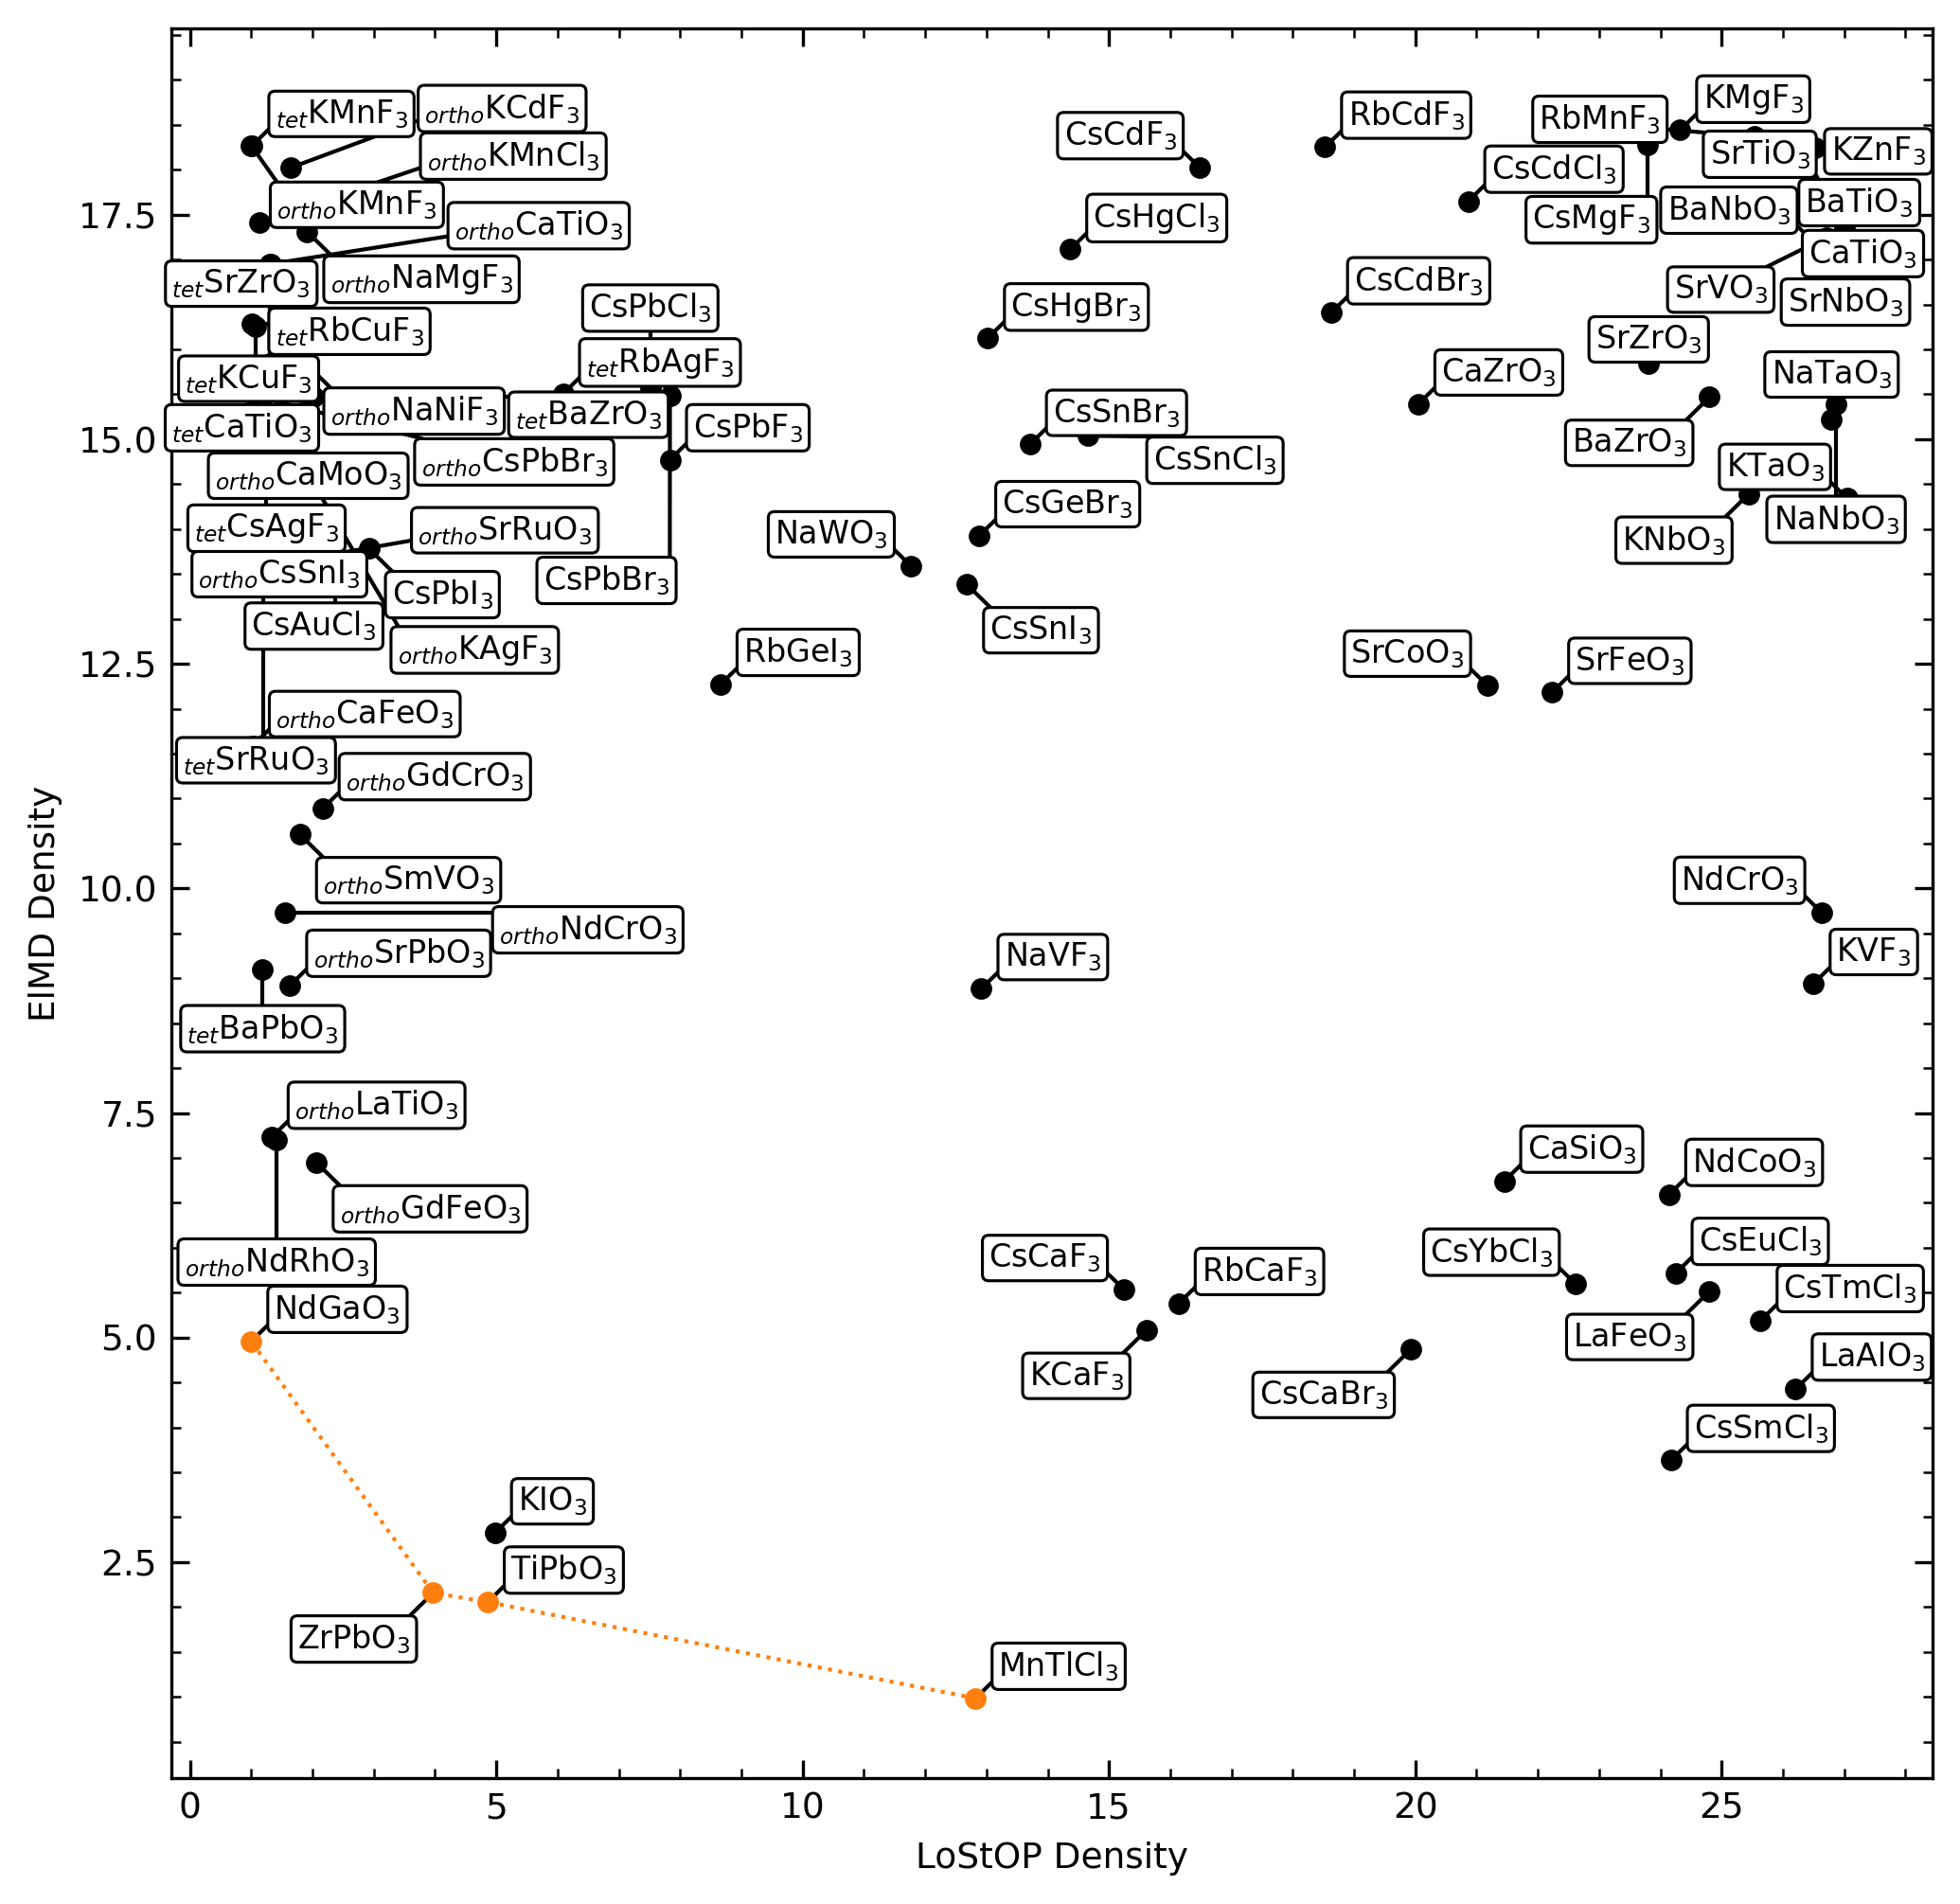

In [22]:
scaled_df = df.copy()

# scale the scaled_df
# scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

# get some nice formula labels
labels = [reduce_single_formula(formula) for formula in scaled_df['formula'].values]
for i, label in enumerate(labels):
    if "[" in data['filename'].values[i]:
        labels[i] = "$_{" + data['filename'].values[i].split(']')[0].split('[')[1] + "}$" + str(label)

fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

# find the pareto optimal points and plot the front
p_idx = is_pareto_efficient(scaled_df[['lostop_density', 'elmd_density']].values, return_mask=False)
pareto_labels = [labels[i] for i in p_idx]
pareto_x = scaled_df['lostop_density'].loc[p_idx]
pareto_y = scaled_df['elmd_density'].loc[p_idx]
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))
ax.plot(pareto_x, pareto_y, color='C1', lw=1, ls=':', marker='None')

# plot points with custom colors for pareto points
for i in range(len(scaled_df)):
    ax.scatter(
        scaled_df['lostop_density'].iloc[i],
        scaled_df['elmd_density'].iloc[i],
        color='C1' if i in p_idx else 'k',
        s=20,
        zorder=9,
    )

# label pareto points
# ta.allocate(ax,
#             x=scaled_df['lostop_density'].loc[p_idx],
#             y=scaled_df['elmd_density'].loc[p_idx],
#             text_list=pareto_labels,
#             x_scatter=scaled_df['lostop_density'].loc[p_idx].values,
#             y_scatter=scaled_df['elmd_density'].loc[p_idx].values,
#             x_lines=[pareto_x],
#             y_lines=[pareto_y],
#             textsize=8,
#             nbr_candidates=10000,
#             linecolor='C1',
#             avoid_crossing_label_lines=True,
#             avoid_label_lines_overlap=True,
#             bbox=dict(boxstyle="round", fc="w", ec="C1", pad=0.2, lw=0.75),
#             zorder=15,
#             )

# drop p_idx indices from scaled_df and labels
# labels = [label for i, label in enumerate(labels) if i not in p_idx]

ta.allocate(ax,
            x=scaled_df['lostop_density'],
            y=scaled_df['elmd_density'],
            text_list=labels,
            x_scatter=scaled_df['lostop_density'].drop(scaled_df.index[p_idx]).values,
            y_scatter=scaled_df['elmd_density'].drop(scaled_df.index[p_idx]).values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            textsize=8,
            nbr_candidates=10000,
            linecolor='k',
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2, lw=0.75),
            zorder=11,
            )

# plt.xlim(-0.05, 1.05)
# plt.ylim(-0.05, 1.05)

# plt.scatter(0.5369274480240577, 0.7804752928075218, marker='s')

# Set labels
ax.set_xlabel("LoStOP Density")
ax.set_ylabel("ElMD Density")
plt.show()

In [23]:
scaled_df['combined_score'] = scaled_df['lostop_density'] + scaled_df['elmd_density']

scaled_df['log_volume'] = np.log(scaled_df['volume'])

scaled_df[scaled_df['lostop_density']==0]

,lostop_density,elmd_density,formula,filename,spacegroup,volume,combined_score,log_volume


In [24]:
scaled_df.to_clipboard()

Attempting to correct my cifs